*Real-world dataset*
The data contains information from the 1990 California census. More info here: https://github.com/ageron/handson-ml2/tree/master/datasets/housing

## Problem Statement
### Given a limited set of attribute of a locality, can we predict housing price in the locality?

The dataset has 20,640 samples and 9 features

    • median income—in tens of thousands, so 8.37 would represent $83,700
    • median house age—in the dataset, the maximum value for this feature is 52
    • number of rooms *within a block*
    • number of bedrooms *within a block*
    • block population 
    • block house occupancy
    • house block latitude
    • house block longitude
    • Ocean proximity 

Each sample also has as its target a corresponding median house value in hundreds of thousands, so 3.55 would represent $355,000. The values is capped at $500,000. 


**CONCEPTS USED**
    | Early data split
    | Feature scaling 
    | One Hot encoding
    | Data Wrangling 
    | Feature Creation 
    | Exploratory Data Analysis  



In [1]:
# Import packages 
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
# %pip install fast_ml
from fast_ml.model_development import train_valid_test_split

#Models 
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

# %pip install xgboost 

import seaborn as sns
import matplotlib.pyplot as plt
import time    #to pause at a line 

import os
clear = lambda: os.system('cls')
clear()

#Loading the dataset 

califDF=pd.read_csv("housing.csv")              #housing is a pandas Dataframe datatype

print(califDF.head()) #prints the first five rows
# Each row indicates one district


# Append target var to the end by convention. Currently it is the second to last. 
# califDF['MedHouseValue'] = pd.Series(calif.target) 


   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


### BASIC stats 

In [2]:
print(califDF.info())

# The dataset contains only a single categorical variable "ocean_proximity"
califDF["ocean_proximity"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

**Type:** All data is continuous, except for the "ocean_proximity" which is categorical \
**Missing Data:** Only one variable "total_bedrooms" has some missing values.


### Dealing with categorical data (on whole data set)

In [3]:
# 1. Categorical data in "ocean_proximity". We need to encode numeric vals for each category 
califDF_ocean = califDF[["ocean_proximity"]]

# print(califDF_ocean)

# from sklearn.preprocessing import OrdinalEncoder
# Cat_encoder = OrdinalEncoder().fit(X_train_ocean)
# X_train_oceanEnc  = Cat_encoder.transform(X_train_ocean)

# Next step is to create dummy variables using one hot encoding method
from sklearn.preprocessing import OneHotEncoder
OneH_encoder = OneHotEncoder(sparse=False).fit(califDF_ocean)
califDF_oceanOneH = OneH_encoder.transform(califDF_ocean)
ocean_cols =  ['ocean1h','oceanIn','oceanNear','oceanBay','oceanIsl']
califDF_oceanOneH = pd.DataFrame(califDF_oceanOneH, columns=ocean_cols)

# Rejoin encoded 'ocean_proximity' to the original dataframe before next step 
# important to reset index of all df being concatenated, else NaNs are added
califDF.reset_index(drop=True, inplace=True)
califDF_oceanOneH.reset_index(drop=True, inplace=True)

califDF_1Hot = pd.concat([califDF, califDF_oceanOneH], axis = 1) 
califDF_1Hot.drop("ocean_proximity", axis=1, inplace=True)  #drop the categroical vals of ocean 

# print(califDF_1Hot)


## Strategy to avoid Data Leakage 

Data leakage happens when knowledge of the hold-out test set 'leaks' into the dataset used to train the model. This can result in an incorrect estimate of model performance when making predictions on new data.
- E.g. if we are interested in selecting the best features/predictors based on EDA, doing it on the *whole* data set would result inherent leakage of data to the model. \

The division between training and test set is an attempt to replicate the situation where you have past information and are building a model which you will test on future as-yet unknown information:
#### A practical option would be to use the train/validation/test paradign RIGHT FROM THE START...
1. Impute and perform EDA on the train set only 
2. Tune model parameters on the validation set
3. and evaluate model performance on the test set 
  
This way, we are sure that the test data is totally unseen by the model. The data set is large enough to allow 3 way splitting. 

In the words of Aurélien Géron (O'Reilly Hands-on Machine Learning)...
<img src = "Oreilly advice.png" alt = "" />

In [4]:
#Splitting data 
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(califDF_1Hot, 
                            target = 'median_house_value', train_size=0.6, valid_size=0.2, test_size=0.2,
                            random_state=1 )

print(pd.DataFrame(X_train).shape)
print(len(y_train))

(12384, 13)
12384


### Dealing with missing data (on training set only)

In [5]:
# 2. Address missing data in 'total_bedrooms'
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median", add_indicator=False)
# using median, instead of mean, for imputation is a better strategy here as we are yet to remove the outliers. 

# Since the median can only be computed on numerical attributes, we should drop the one hot encoded variables.
X_train_num = X_train.drop(ocean_cols, axis=1) 
imputer.fit(X_train_num)
X = imputer.transform(X_train_num)
# X is a numpy array. Convert it to df
X_train_Imputed = pd.DataFrame(data =X, columns=X_train_num.columns)

# print(imputer.feature_names_in_)
print('The value calculated for imputation for all columns, in order = ' +  str(imputer.statistics_))

# Now, plug back the ocean proximity data. But after resetting index. 
X_train_Imputed.reset_index(drop=True, inplace=True)
X_train_ocean = X_train[ocean_cols] 
X_train_ocean.reset_index(drop=True, inplace=True)
X_train_Imputed = pd.concat([X_train_Imputed, X_train_ocean], axis = 1)
# print(X_train_Imputed) 


The value calculated for imputation for all columns, in order = [-118.52      34.27      29.      2127.       434.      1162.
  408.         3.53895]


## In-depth Data Exploration 
After accounting for missing values, we can now plot the data and explore distributions and correlations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12384 entries, 0 to 12383
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           12384 non-null  float64
 1   latitude            12384 non-null  float64
 2   housing_median_age  12384 non-null  float64
 3   total_rooms         12384 non-null  float64
 4   total_bedrooms      12384 non-null  float64
 5   population          12384 non-null  float64
 6   households          12384 non-null  float64
 7   median_income       12384 non-null  float64
 8   median_house_value  12384 non-null  float64
dtypes: float64(9)
memory usage: 870.9 KB
***The target variable is : median_house_value
          longitude      latitude  housing_median_age   total_rooms  \
count  12384.000000  12384.000000        12384.000000  12384.000000   
mean    -119.582637     35.641461           28.516957   2634.749354   
std        2.005132      2.135181           12.6057

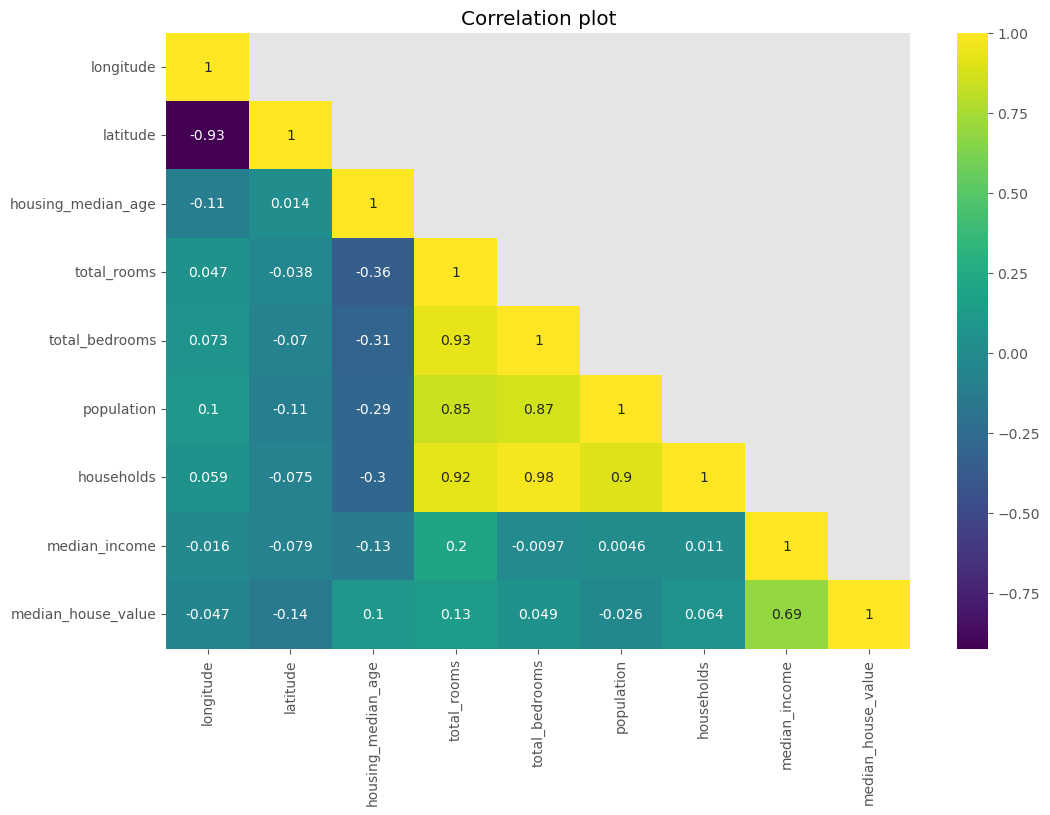

Top features correlated to Target (+ve or -ve)
+--------------------+----------------------+
|                    |   median_house_value |
|--------------------+----------------------|
| median_house_value |            1         |
| median_income      |            0.688697  |
| latitude           |           -0.14173   |
| total_rooms        |            0.134524  |
| housing_median_age |            0.0995051 |
| households         |            0.064181  |
+--------------------+----------------------+
BOXPLOTS, EXCLUDING CATEGORICAL FEATURES


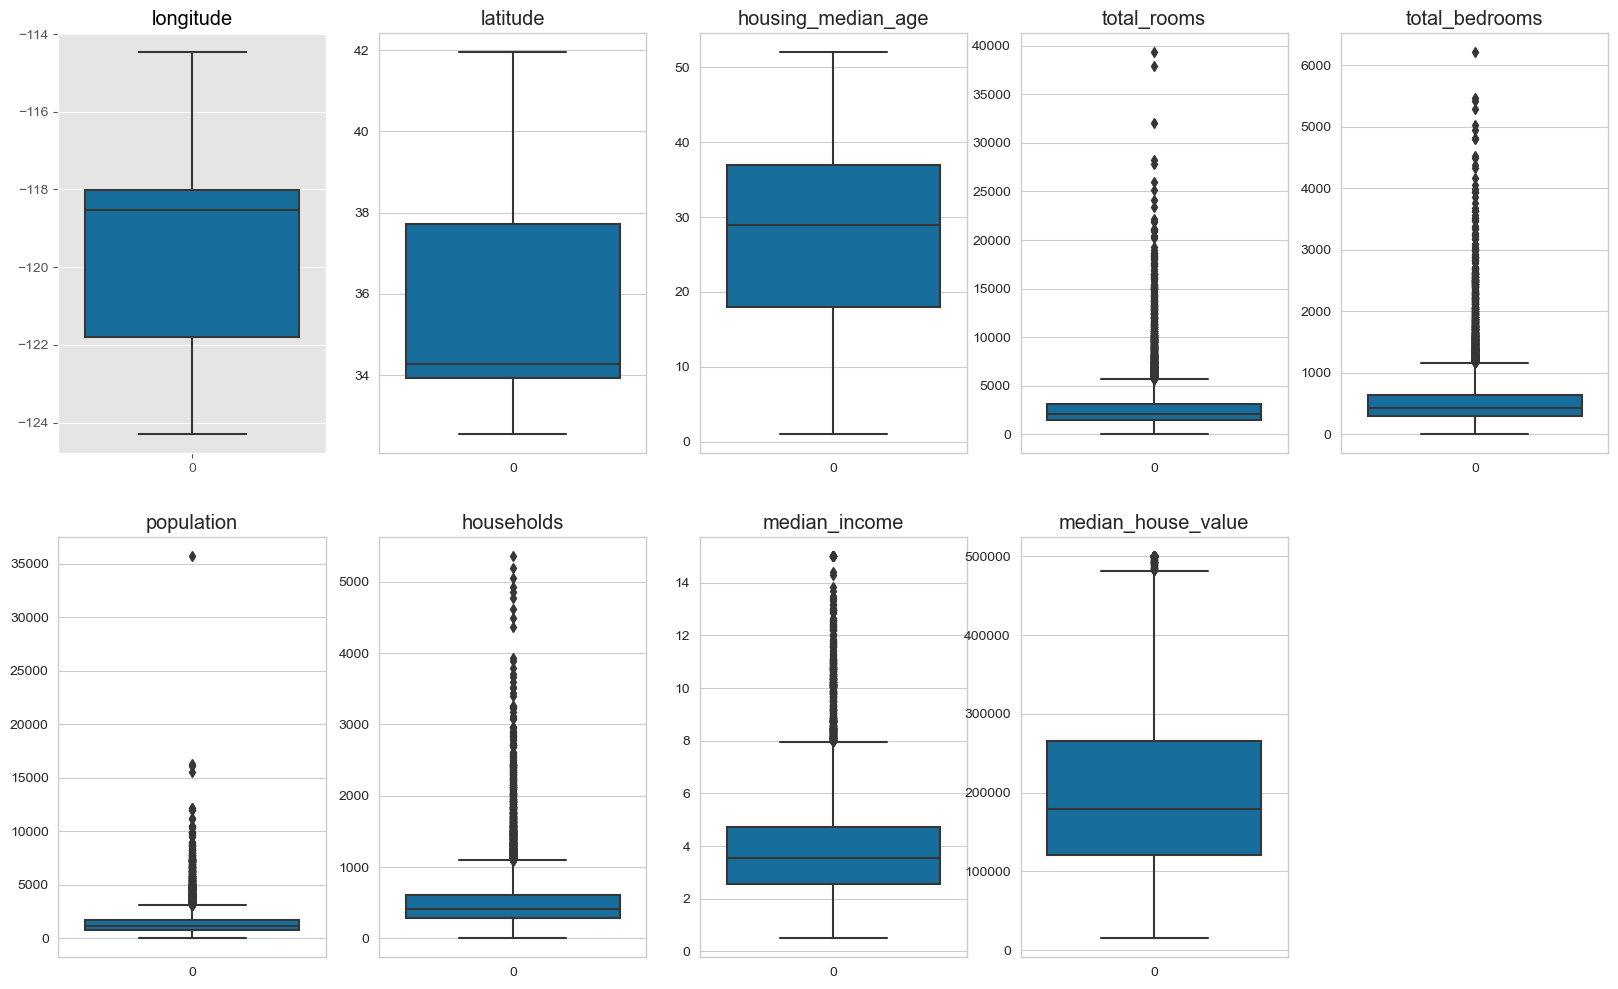

DENSITY PLOTS


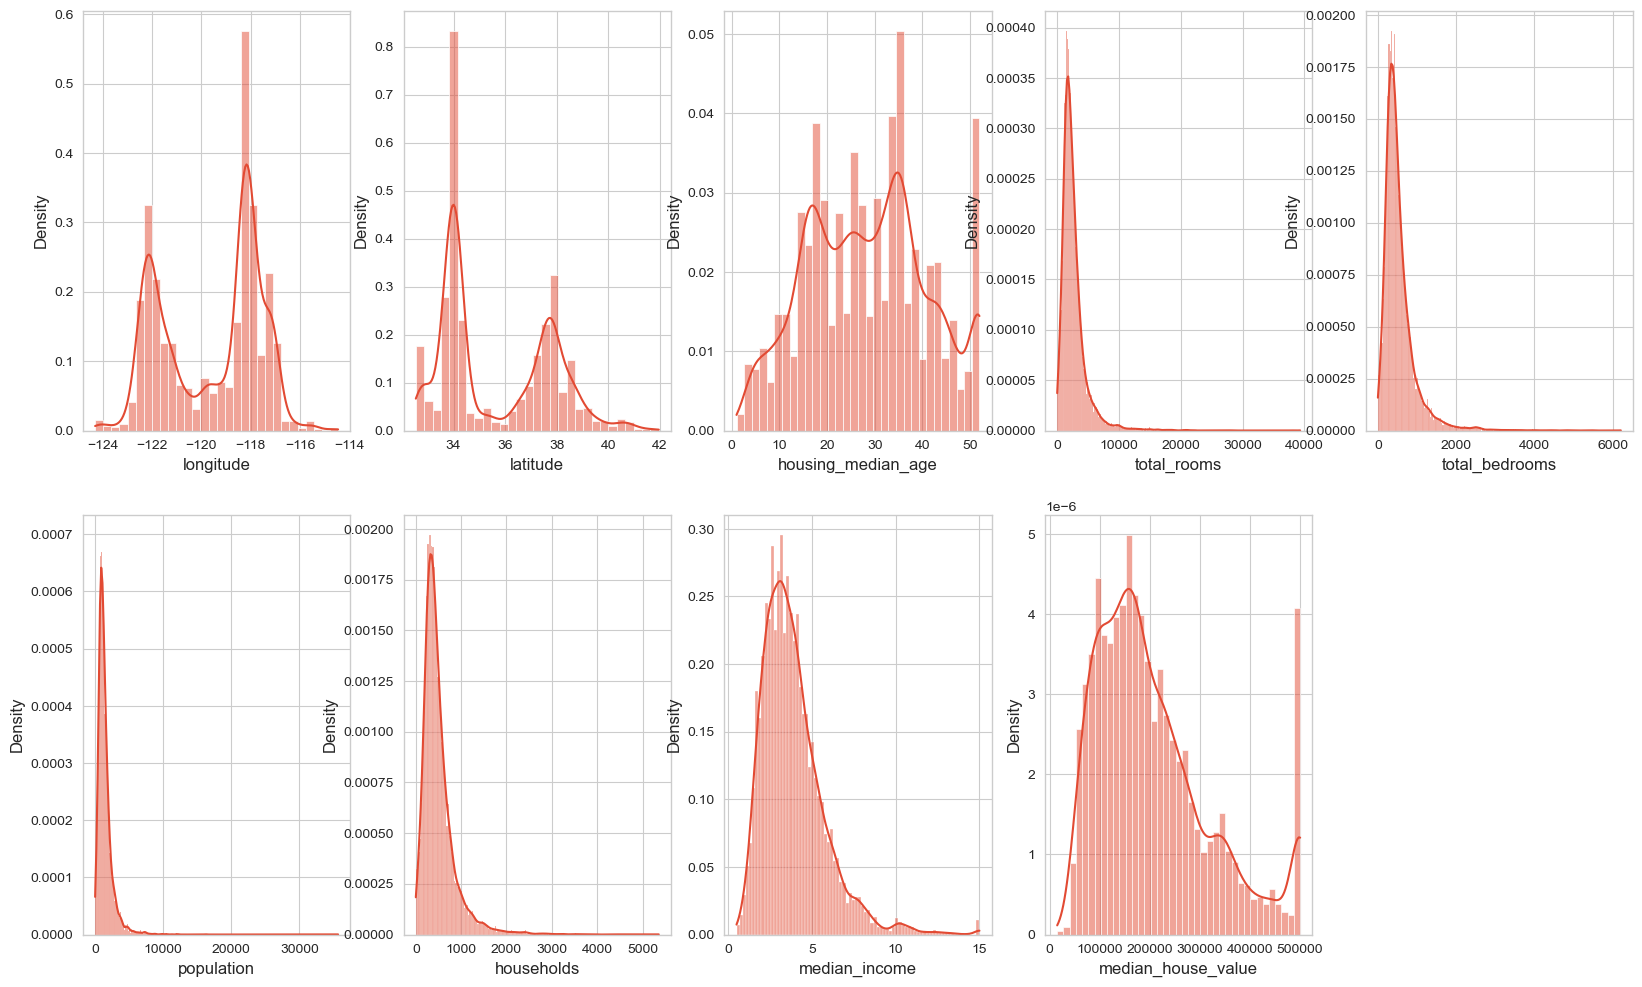

SCATTER PLOTS


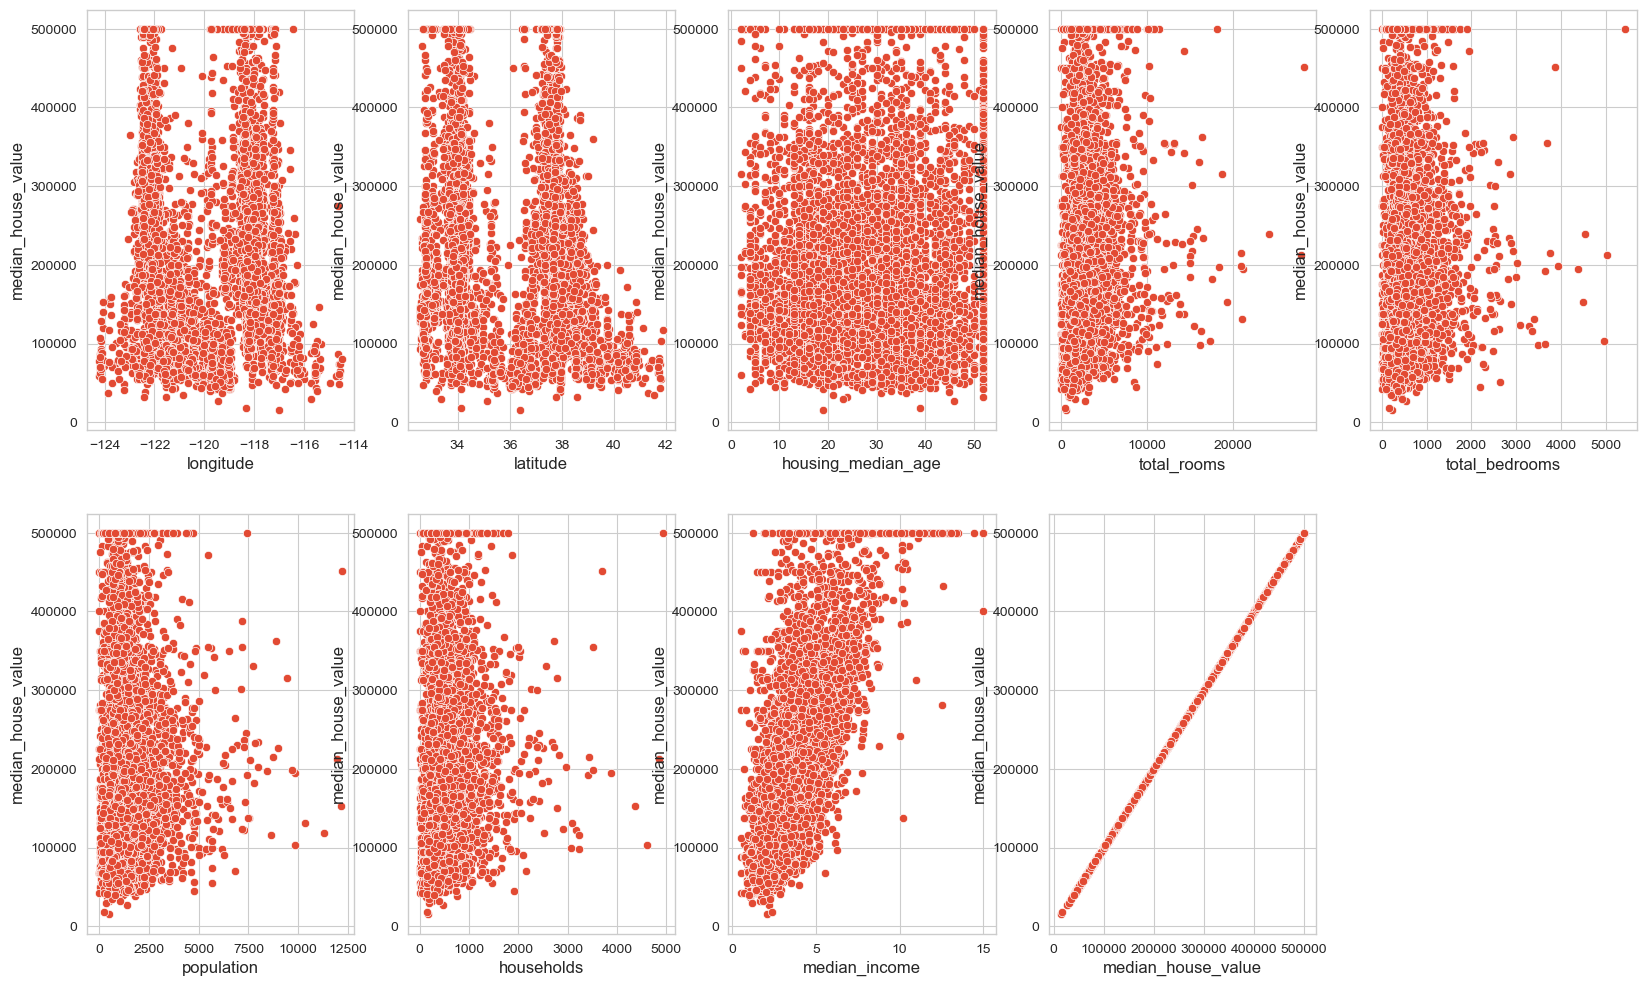

In [6]:
# CREATING A CUSTOM df FROM THE TRAIN SET FOR DATA ANALYSIS 
# first append the target variable at the end 
y_train.reset_index(drop=True, inplace=True)
Xy_train_Imputed = pd.concat([X_train_Imputed, y_train], axis = 1)

DF= Xy_train_Imputed.copy()  #copy the Xtrain to new 'DF' for analysis file 

# Drop categorical variables for a better visualization 
DF.drop(labels=ocean_cols, axis = 1, inplace=True)

### For plotting, we call a custom script 
%run EDAscript_copy.ipynb   #keep a copy in the same folder   
# %run "C:/Users/Zohaib/repos/Fundamentals/EDAscript.ipynb"  #assumes that a var. DF already exists in the workspace 


# **Observations** 
1. <u> Highly correlated features </u> \
   a)   Several features such as 'total_rooms' and 'total_bedrooms', 'population' and 'total_rooms', and 'total_rooms' and 'households' are highly correlated (r>0.8). So we can actually keep only the 'total_rooms' and drop the other two.  \
   b)   Longitude and Latitude are highly correlated (negatively). One of these could be removed. 

2. <u> Outliers </u> \
   a)   From density and scatter plots, we see 'total_rooms' going into 1000s which is impossible. These can be dropped with a reasonable criterion. 
   


### Removing correlated features and outliers


In [7]:
# make a copy of the latest version of X_train. Keep y_train in the df to remove corr target var vals as well
Xy_train_df = Xy_train_Imputed.copy()

# We can use standard deviation (z-scores) to remove more outliers if we wish 
def remove_outliers(df,columns,n_std): 
    '''input data frame, column names and vals to remove in terms of  no. of s.d. away from mean '''
    # The common industry practice is to use 3 standard deviations away from the mean to differentiate outlier from non-outlier. https://stephenallwright.com/remove-outliers-pandas/ 

    for col in columns:
        print('Working on column: {}'.format(col))
        # startLen = len(df[col])
        # print(startLen)

        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))] #removes complete row outside of this range for 'col'
        
    return df


Xy_train_df = remove_outliers(Xy_train_df, Xy_train_df.columns.values, 3)
Xy_train_df.reset_index(drop=True, inplace = True)  # necessary to reflect new reduced shape 
print(Xy_train_df.tail())

# Next remove unnecessary features 
Xy_train_reduced = Xy_train_df.drop(['total_bedrooms', 'longitude'],axis=1)
print(Xy_train_reduced.tail())

# Do the same for valid and test data 
X_test_reduced = X_test.drop(['total_bedrooms', 'longitude'],axis=1)
X_valid_reduced = X_valid.drop(['total_bedrooms', 'longitude'],axis=1)


Working on column: longitude
Working on column: latitude
Working on column: housing_median_age
Working on column: total_rooms
Working on column: total_bedrooms
Working on column: population
Working on column: households
Working on column: median_income
Working on column: ocean1h
Working on column: oceanIn
Working on column: oceanNear
Working on column: oceanBay
Working on column: oceanIsl
Working on column: median_house_value
       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
11423    -117.88     33.76                17.0       1768.0           474.0   
11424    -119.63     34.42                42.0       1765.0           263.0   
11425    -118.26     33.93                42.0       1433.0           295.0   
11426    -117.16     33.73                10.0       2381.0           454.0   
11427    -122.20     37.79                35.0       1802.0           459.0   

       population  households  median_income  ocean1h  oceanIn  oceanNear  \
11423      1079.0 

# Introducing new features 
- Some of the attributes total number of rooms in a block are not useful attributes in determining house value unless we know the total housholds there are in that block. 
- Similarly, population per house is more logical than total block population. 

**We can create some custom attributes by combining some existing attributes**

In [8]:
NewAttrib1 = Xy_train_reduced['total_rooms']/Xy_train_reduced['households']
NewAttrib2 = Xy_train_reduced['population']/Xy_train_reduced['households'] 

#insert new features in the df just before last column 
Xy_train_reduced.insert(loc = len(Xy_train_reduced.columns.values)-1, 
                                    column = 'rooms_per_household',   value=NewAttrib1)
Xy_train_reduced.insert(loc = len(Xy_train_reduced.columns.values)-1, 
                                    column = 'popolation_per_household', value=NewAttrib2)

# print(Xy_train_reduced)

# Remove outliers from newly created features as well 
Xy_train_reduced = remove_outliers(Xy_train_reduced, Xy_train_reduced.columns.values, 3)

## Observe any correlation of newly created features with the target variable 
corr_matrix = Xy_train_reduced.corr()
k = 6
cols = corr_matrix.abs().nlargest(k, 'median_house_value', keep = 'all')['median_house_value'].index 
cm = Xy_train_reduced[cols].corr()

from tabulate import tabulate
x = cm['median_house_value'].to_frame()    #print only first column which has corr with targt var. 
print('Top features correlated to Target (+ve or -ve)' )
print(tabulate(x, headers='keys', tablefmt='psql'))


# Split saving variables for features and target for future use 
X_train_reduced = Xy_train_reduced.drop(['median_house_value'],axis=1)
y_train_reduced = Xy_train_reduced['median_house_value']

X_test_reduced.reset_index(drop=True, inplace = True)
X_valid_reduced.reset_index(drop=True, inplace = True)
# adding new features to *test* and *validation* data as well 
X_test_reduced.insert(loc = len(X_test_reduced.columns.values), 
                                    column = 'rooms_per_household',   value=NewAttrib1)
X_test_reduced.insert(loc = len(X_test_reduced.columns.values), 
                                    column = 'popolation_per_household', value=NewAttrib2)

X_valid_reduced.insert(loc = len(X_valid_reduced.columns.values), 
                                    column = 'rooms_per_household',   value=NewAttrib1)
X_valid_reduced.insert(loc = len(X_valid_reduced.columns.values), 
                                    column = 'popolation_per_household', value=NewAttrib2)

# print(np.isnan(X_test_reduced)) 



Working on column: latitude
Working on column: housing_median_age
Working on column: total_rooms
Working on column: population
Working on column: households
Working on column: median_income
Working on column: ocean1h
Working on column: oceanIn
Working on column: oceanNear
Working on column: oceanBay
Working on column: oceanIsl
Working on column: rooms_per_household
Working on column: popolation_per_household
Working on column: median_house_value
Top features correlated to Target (+ve or -ve)
+--------------------------+----------------------+
|                          |   median_house_value |
|--------------------------+----------------------|
| median_house_value       |             1        |
| median_income            |             0.648838 |
| oceanIn                  |            -0.492591 |
| popolation_per_household |            -0.301701 |
| ocean1h                  |             0.259297 |
| rooms_per_household      |             0.244549 |
+--------------------------+-------

**Clearly the newly developed population_per_household feature has a better negative correlation (-0.3) with the median house price**

#### Save clean CSV files
After the cleaning, it is a good idea to save the clean csv file in the same folder 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10883 entries, 0 to 11427
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitude                  10883 non-null  float64
 1   housing_median_age        10883 non-null  float64
 2   total_rooms               10883 non-null  float64
 3   population                10883 non-null  float64
 4   households                10883 non-null  float64
 5   median_income             10883 non-null  float64
 6   rooms_per_household       10883 non-null  float64
 7   popolation_per_household  10883 non-null  float64
 8   median_house_value        10883 non-null  float64
dtypes: float64(9)
memory usage: 850.2 KB
***The target variable is : median_house_value
           latitude  housing_median_age   total_rooms    population  \
count  10883.000000        10883.000000  10883.000000  10883.000000   
mean      35.676985           29.589451   2180.129376   

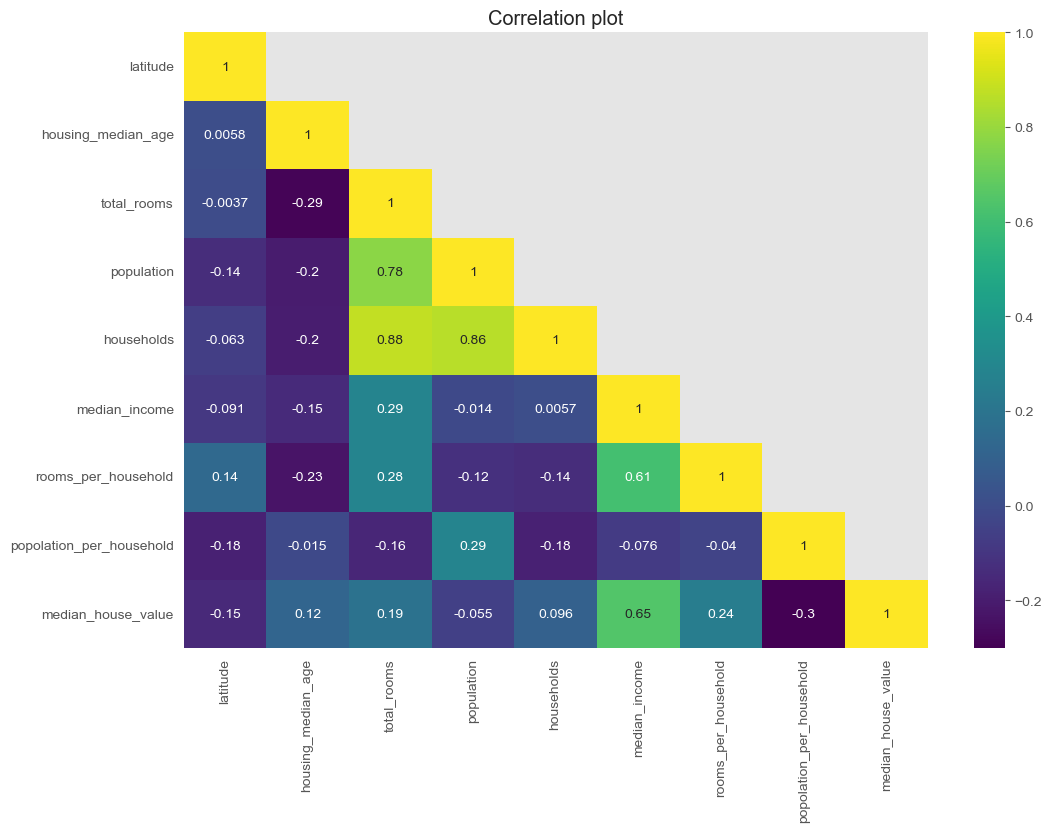

Top features correlated to Target (+ve or -ve)
+--------------------------+----------------------+
|                          |   median_house_value |
|--------------------------+----------------------|
| median_house_value       |             1        |
| median_income            |             0.648838 |
| popolation_per_household |            -0.301701 |
| rooms_per_household      |             0.244549 |
| total_rooms              |             0.187433 |
| latitude                 |            -0.151363 |
+--------------------------+----------------------+
BOXPLOTS, EXCLUDING CATEGORICAL FEATURES


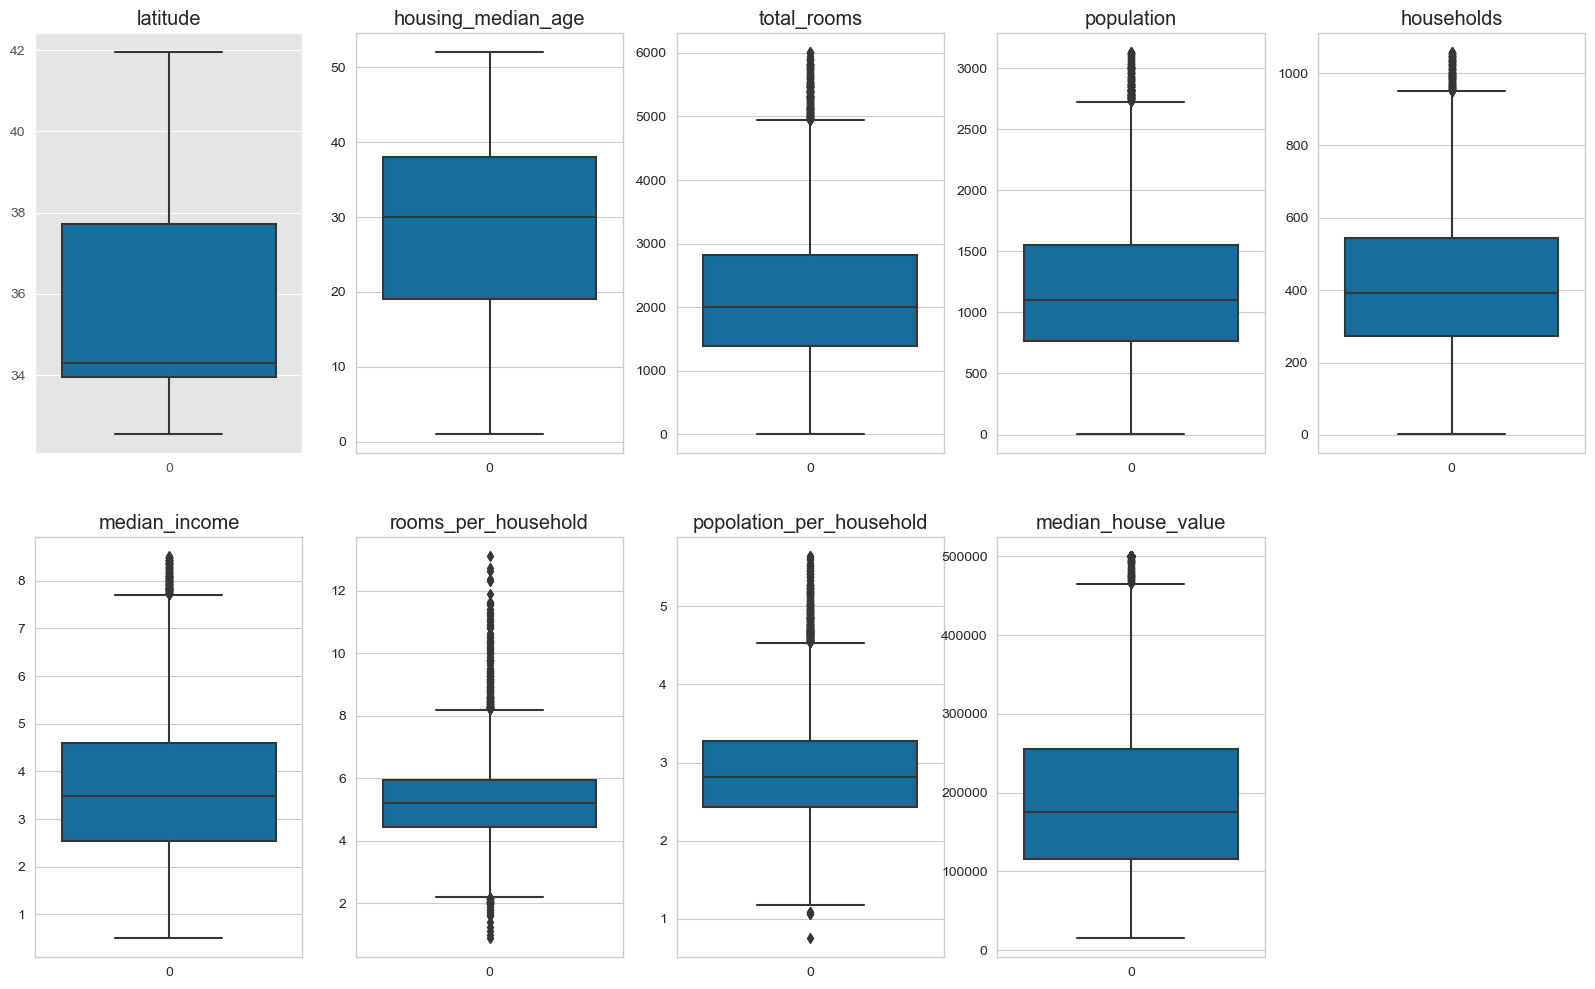

DENSITY PLOTS


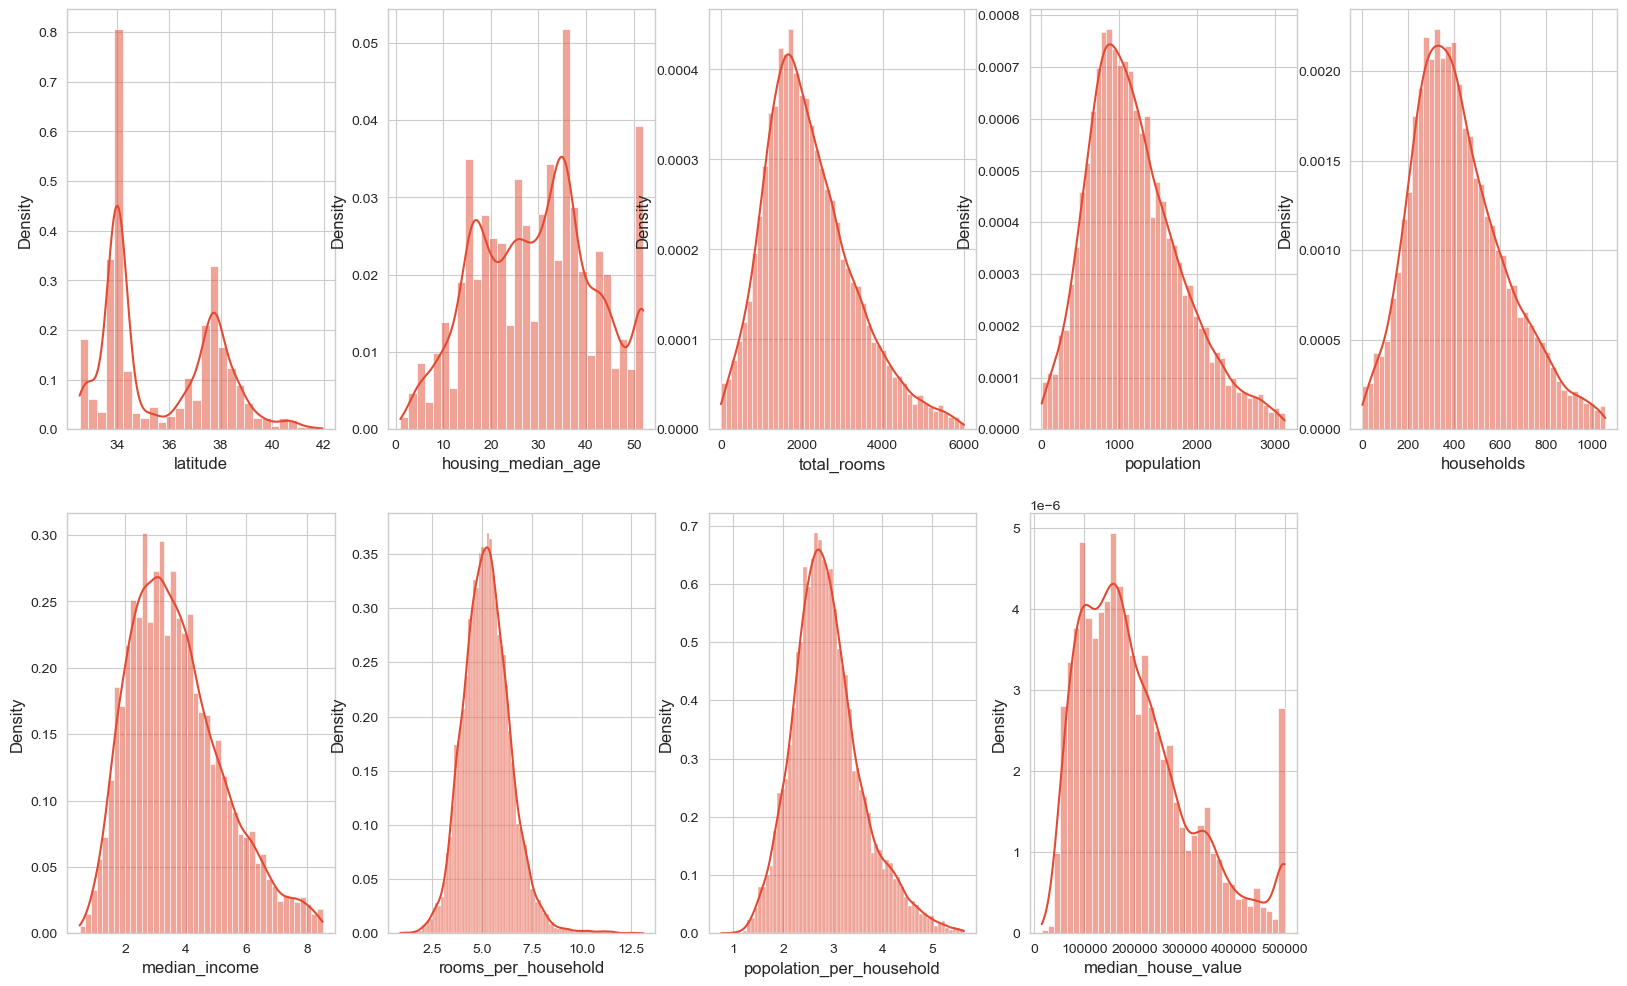

SCATTER PLOTS


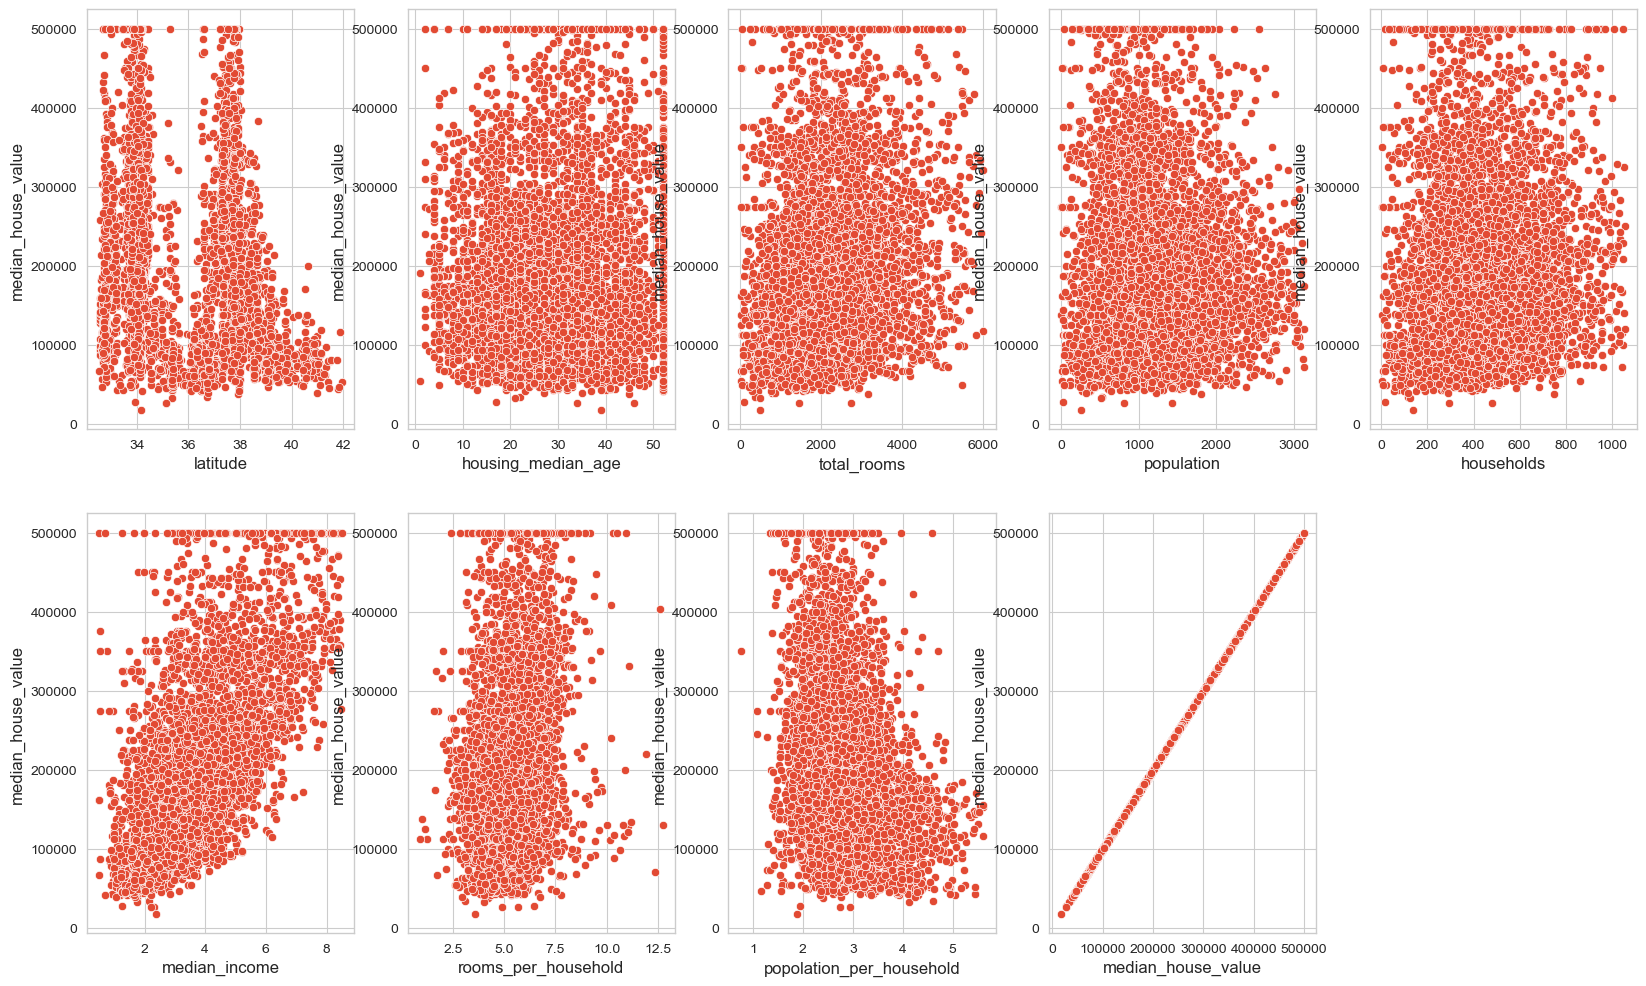

In [9]:
Xy_train_reduced.to_csv ('housing_train_clean.csv', index = False, header=True) 
#while at it, we can also save the test data in a separate file 

y_test.reset_index(drop=True, inplace = True)
Xy_test = pd.concat([X_test_reduced, y_test], axis = 1)
Xy_test.to_csv ('housing_test.csv', index = False, header=True) #also save 



#------ Optional: Run EDA on cleaned data ---------
DF = Xy_train_reduced.copy()
DF.drop(labels=ocean_cols, axis = 1, inplace=True)  #disregard corr matrix in this case then
%run EDAscript_copy.ipynb 

#### Feature Scaling
Since there is a lot of range variation with respect to different attribute of the data , it is preferable for us to either
- **standardize**( Standard Scalar : scaling the data in such a way that the mean of the data is 0 and standard deviation is 1) $${(x-\mu)}/{\sigma}$$  
or
- **normalize** (min-max scaler : by subtracting minimum element and diving by difference of maximum and minimum element) the data $${(x-x_{min})}/{(x_{max}-x_{min})}$$

In [10]:
# We take the first approach here 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_reduced)         # fit only on training data

X_train_scaled = scaler.transform(X_train_reduced)

# Now apply same transformation to validation and test sets
X_test_scaled  = scaler.transform(X_test_reduced)  
X_valid_scaled  = scaler.transform(X_valid_reduced)  

# print(X_train)

# Baseline model, Linear Regression 


In [25]:

linregModel = LinearRegression().fit(X = X_train_scaled , y = y_train_reduced)
# print("Coefficients: \n", linregModel.coef_.flatten()) 

# print('The regression coeffs for each feature are: \n')
# for i,name in enumerate(X.columns.values):   
#     print(f'{name:<10}: {linreg.coef_[i] :.3f}')

print(f'The R2 score on train set is: {linregModel.score(X_train_scaled, y_train_reduced):.2f}')   #perf on training data 

# Before moving on, we can perform cross-validation to confirm above metric
kf = KFold(n_splits = 5,shuffle = True, random_state = 30)  #doing 'n_splits' divisions of data and shuffling each time
linregCV = LinearRegression() 
cv_results = cross_val_score(linregCV, X_train_scaled, y_train_reduced, cv=kf)      #Returns R2 score for all folds

print('The cross-validation R2 score is: ' +  str(cv_results))
print(f'Mean R2 score = {np.mean(cv_results):.2f}' )



The R2 score on train set is: 0.62
The cross-validation R2 score is: [0.60910528 0.62169502 0.63473472 0.62522407 0.61719531]
Mean R2 score = 0.62


## Evaluating on Test data


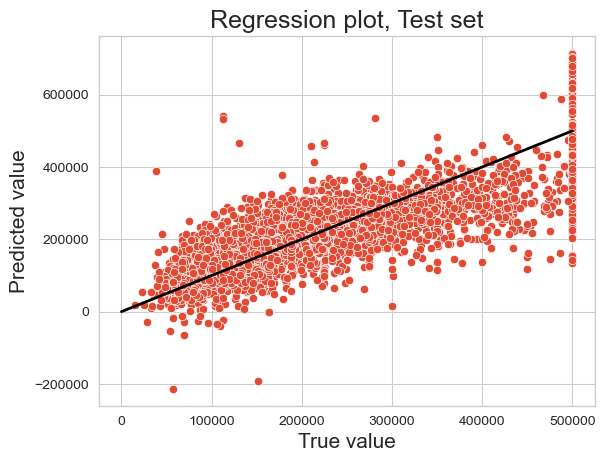

Test R2 score is 0.59 while RMSE is 74204.46


In [12]:
y_true = y_test
y_pred = linregModel.predict(X_test_scaled)

# in order to plot them together, make a DF first
dfPredTrue = pd.DataFrame()
dfPredTrue['Truth'] = y_true
dfPredTrue['Predicted'] = y_pred
scatplot = sns.scatterplot(data = dfPredTrue, x = 'Truth', y = 'Predicted')

plt.plot([0, y_true.max()], [0, y_true.max()], linewidth=2, color = 'black')  #draw a diagonal line through the data 
plt.title('Regression plot, Test set', fontsize=18)
plt.xlabel('True value', fontsize=15)
plt.ylabel('Predicted value', fontsize=15)
plt.show()

# Metrics 
R2_test = metrics.r2_score(y_true, y_pred)  #0.59, some correlation but not great 
RMSE_test = metrics.mean_squared_error(y_true, y_pred, squared=False)  #take RMSE instead by using False 
print('Test R2 score is ' + '%.2f'% R2_test + ' while RMSE is ' + '%.2f'% RMSE_test)


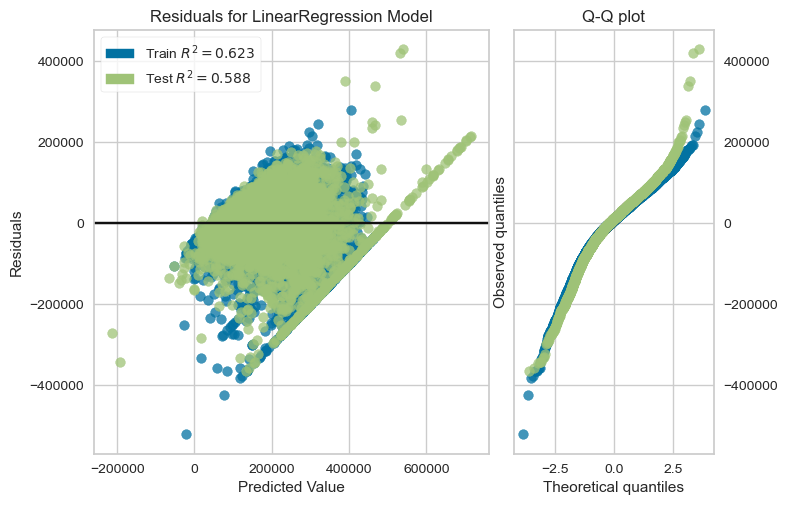

<AxesSubplot: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [13]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

visualizer1 = ResidualsPlot(linregModel,  
                            hist = False, qqplot=True, train_alpha=0.75, test_alpha=0.75)
visualizer2 = PredictionError(linregModel)

visualizer1.fit(X_train_scaled , y_train_reduced)  # Fit the training data to the visualizer
visualizer1.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer1.show()                 # Finalize and render the figure

# visualizer2.fit(X_train_scaled , y_train_reduced)  # Fit the training data to the visualizer
# visualizer2.score(X_test_scaled, y_test)  # Evaluate the model on the test data
# visualizer2.show() 


### The train and test R2 score of around 0.62 is good but not great! 
#### A typical predication error of US$70k in the price of the house is not very satisfying either. 
There are a few steps we can take to improve it in future:
- **Introducing more relevant features.** With this data set, we attempted to estimate house price somewhat indirectly i.e. through overall block population and average room and household data. Specific information on the area of the house could improve the prediction 
- **Using a more powerful model** such as a decision tree or random forest 
- **Optimizing for hyper-parameters** using grid CV approach 

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor


# Tree based and ensemble models
DecTree = DecisionTreeRegressor(random_state=10).                  fit(X_train_scaled, y_train_reduced) 
RFreg = RandomForestRegressor(random_state=10).                    fit(X_train_scaled, y_train_reduced) 
GBreg = GradientBoostingRegressor(random_state=10).                fit(X_train_scaled, y_train_reduced) 
AdaBoostreg = AdaBoostRegressor(random_state=10).                  fit(X_train_scaled, y_train_reduced) 
XGBoostreg = XGBRegressor(random_state=10).                         fit(X_train_scaled, y_train_reduced) 

# #we can print the hyperparameters used by default using the fol fcn
# DecTree.get_params()


In [15]:
# Combining together all r2 scores form different algos

#in a table 
names = ['Decision tree', 'Random Forest', 'Gradient Boost', 'AdaBoost', 'XGBoost']

results = [[DecTree.score(X_train_scaled, y_train_reduced), DecTree.score(X_test_scaled, y_test)],
        [RFreg.score(X_train_scaled, y_train_reduced),   RFreg.score(X_test_scaled, y_test)],
        [GBreg.score(X_train_scaled, y_train_reduced),  GBreg.score(X_test_scaled, y_test)],
        [AdaBoostreg.score(X_train_scaled, y_train_reduced),  AdaBoostreg.score(X_test_scaled, y_test)],
        [XGBoostreg.score(X_train_scaled, y_train_reduced),    XGBoostreg.score(X_test_scaled, y_test)]
]

results = [[round(num,2) for num in mylist] for mylist in results] 
# print(results)

nPlusr = list(zip(names, results))  #create a list of tuples 

from tabulate import tabulate
print("***Tree and Ensemble methods,\n Before hyperparameter tuning***")
print(tabulate(nPlusr, headers = ['Algorithm','R2 scores \n [Train, Test]'], tablefmt='pretty'))



***Tree and Ensemble methods,
 Before hyperparameter tuning***
+----------------+----------------+
|   Algorithm    |   R2 scores    |
|                |  [Train, Test] |
+----------------+----------------+
| Decision tree  |  [1.0, 0.24]   |
| Random Forest  |  [0.97, 0.53]  |
| Gradient Boost |  [0.76, 0.57]  |
|    AdaBoost    |  [0.53, 0.45]  |
|    XGBoost     |  [0.92, 0.54]  |
+----------------+----------------+


All regressors are overfitting the data at default values. 
The Decision tree and Random forest are can be fixed easily by limiting the value of  'max_depth' parameter (say 6). 
However, we will take a more systemic approach and find the OPTIMAL model using 'RandomSearchCV'. 
AdaBoost has the worst result so can be skipped for future tuning.

## Hyperparameter tuning

In [16]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

DecTree = DecisionTreeRegressor(random_state=10)
RFreg = RandomForestRegressor(random_state=10)
GBreg = GradientBoostingRegressor(random_state=10)
XGBoostreg = XGBRegressor(random_state=10)

param1 = {}     #grid for Decision tree
param1['regressor'] = [DecTree]
param1['regressor__max_depth'] = np.arange(2,12)
param1['regressor__min_samples_split']= np.arange(2, 8)
param1['regressor__min_samples_leaf']= np.arange(5, 10)
param1['regressor__min_impurity_decrease'] = [0, 0.001, 0.002, 0.003]

param2 = {}  #Random forests
param2['regressor'] = [RFreg]
param2['regressor__max_depth'] = np.arange(2,12) 
param2['regressor__min_samples_split']= np.arange(2, 8)
param2['regressor__min_samples_leaf']= np.arange(5, 10)
param2['regressor__min_impurity_decrease'] = [0, 0.001, 0.002, 0.003]
param2['regressor__n_estimators'] = [10, 50, 100, 200]
param2['regressor__max_features'] = np.arange(0.2, 0.9, 0.1)

param3 = {}  #Gradient Boost
param3['regressor'] = [GBreg]
param3['regressor__max_depth'] = np.arange(2,12) 
param3['regressor__n_estimators'] = [10, 50, 100,200]
param3['regressor__criterion']= ['friedman_mse','squared_error', 'mse']
param3['regressor__min_samples_split']= np.arange(2, 8)
param3['regressor__min_samples_leaf']= np.arange(5, 8)
param3['regressor__min_impurity_decrease'] = [0, 0.001, 0.002, 0.003]
param3['regressor__max_features'] = np.arange(0.2, 0.8, 0.1)

param4 = {} #XG Boost 
param4['regressor'] = [XGBoostreg]
param4['regressor__max_depth'] = np.arange(2,12) 

pipeline = Pipeline([('regressor', DecTree)])
params = [param1, param2, param3, param4]
# print(params)
# print('*' * 80)

# grid = GridSearchCV(pipeline, params, scoring=None, cv=5, n_jobs= -1, verbose = 2,
                    #  return_train_score=True) 

# grid = RandomizedSearchCV(pipeline, params, scoring=None, cv=8, n_jobs= -1, verbose = 2,
#                      return_train_score=True, n_iter = 20, random_state=10) 


paramRF = {}  #Random forests
paramRF['max_depth'] = np.arange(2,12) 
paramRF['min_samples_split']= np.arange(2, 8)
paramRF['min_samples_leaf']= np.arange(5, 10)
paramRF['min_impurity_decrease'] = [0, 0.001, 0.002, 0.003]
paramRF['n_estimators'] = [10, 50, 100, 200]
paramRF['max_features'] = np.arange(0.2, 0.9, 0.1)

grid = RandomizedSearchCV(RFreg, paramRF, scoring=None, cv=8, n_jobs= -1, verbose = 2,
                     return_train_score=True, n_iter = 10, random_state=10) 
# verbose = 2 tells about the number of fits, which can give an idea of how long will the model take in tuning
# n_jobs = -1 so that all CPU cores can be run parallelly to optimize the Search



In [17]:
#Here we fit all the 'different' models on the data provided. takes time. 
grid.fit(X_train_scaled, y_train_reduced)   

# print best parameter after tuning
print(grid.best_estimator_)
grid.best_score_



Fitting 8 folds for each of 10 candidates, totalling 80 fits
RandomForestRegressor(max_depth=11, max_features=0.4000000000000001,
                      min_impurity_decrease=0, min_samples_leaf=5,
                      min_samples_split=4, random_state=10)


0.7414019230772446

### Lets build our model with the Optimal parameters just discovered and test on validation set 

In [18]:
# GBregOPT = GradientBoostingRegressor(
#    criterion='squared_error',
#     max_depth=8,
#     max_features=0.4000000000000001,
#     min_impurity_decrease=0,
#     min_samples_leaf=5,
#     min_samples_split=3,
#     n_estimators=200,
#     random_state=10
# )

GBregOPT = RandomForestRegressor(max_depth=11, max_features=0.4000000000000001,
                      min_impurity_decrease=0, min_samples_leaf=5,
                      min_samples_split=4, random_state=10)

GBregOPT.fit(X_train_scaled, y_train_reduced) 
print(metrics.r2_score(y_train_reduced, GBregOPT.predict(X_train_scaled)))

# Testing the model on the Validation set we set aside in the beginning 
print(metrics.r2_score(y_valid, GBregOPT.predict(X_valid_scaled))) 


0.8319257462019262
0.5686674897227233


In [19]:

# Now we want to test our BEST model on the TEST data 
print(metrics.r2_score(y_test, GBregOPT.predict(X_test_scaled)))


0.558115741473457


In [20]:


print(GBregOPT.score(X_test_scaled, y_test))


0.558115741473457


In [21]:
# %pip install scikit-optimize
# https://scikit-optimize.github.io/stable/

from skopt import BayesSearchCV



In [22]:

# results = print(
# f'Decision Tree Train r2 score: {regtree.score(X_train_scaled, y_train_reduced):.2f}\n ' +
# f'_____________Test r2 score: {regtree.score(X_test_scaled, y_pred):.2f}\n ' +
# f'Random forest Train r2 score:{RFreg.score(X_train_scaled, y_train_reduced):.2f}\n '   +
# f'_____________Test r2 score: {RFreg.score(X_test_scaled, y_pred):.2f}\n '+

# f'Gradient Boosting Train r2 score: {GBreg.score(X_train_scaled, y_train_reduced):.2f}\n '+
# f'_____________Test r2 score: {GBreg.score(X_test_scaled, y_pred):.2f}\n '+

# f'Ada Boost Train r2 score: {AdaBoostreg.score(X_train_scaled, y_train_reduced):.2f} \n' +
# f'_____________Test r2 score:  {AdaBoostreg.score(X_test_scaled, y_pred):.2f} \n' +

# f'XG Boost Train r2 score: {XGBoostreg.score(X_train_scaled, y_train_reduced):.2f} \n'
# f'_____________Test r2 score: {XGBoostreg.score(X_test_scaled, y_pred):.2f} \n'

# )